### Predicting S&P500 stock returns: random search model hyperparameters

This program searches parameter space to find optimal values for a number of neural network hyperparameters. The input data comes from two sources: monthly data for S&P500 stocks and SPY monthly data. See the related data generating programs for details.

The network is a single hidden layer network. It uses ADAM for optimization as well as L2-regularization and dropout. The parameters of interest are (1) number of nodes in the hidden layer, (2) learning rate, (3) minibatch size, and (4) activation function. 
 
 

March 2018

Murat Aydogdu

In [1]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
import pandas as pd
import numpy as np

In [3]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from collections import Counter
import time

In [6]:
import random

In [7]:
np.random.seed(31)
random.seed(31) 
tf.set_random_seed(31)

In [8]:
# Neural net predictions
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

In [9]:
pd.options.display.float_format = '{:20,.4f}'.format

## Forming the base data sets

The main input is SP500_Long_V4.CSV, the times series data of time-series and cross-sectionally scaled return and volume and lags of these. To that, I append SPY data.

In [10]:
dflong = pd.read_csv("SP500_Long_V4.CSV")
print dflong.shape
#display(dflong)
#dflong.Date.unique()

(72802, 122)


In [11]:
# Index data: keep SPY returns only
indices = pd.read_csv("Indices_Wide_V4.CSV")
print indices.shape
#indices.Date.unique()

# Only grab SPY returns
d_col = ['Date']
spy_cols = spy_cols = ['RT SPY', 'RT01 SPY', 'RT02 SPY', 'RT03 SPY', 'RT04 SPY', 'RT05 SPY', 'RT06 SPY', 'RT07 SPY', 'RT08 SPY', 'RT09 SPY', 'RT10 SPY', 'RT11 SPY', 'RT12 SPY']
indices = indices[d_col + spy_cols]
#display(indices)

# merge market data with stock data
dflong = dflong.merge(indices, how='left', on='Date', sort=False)
print dflong.shape
display(dflong)

(178, 82)
(72802, 135)


,Ticker,Date,V,P,AV,R,DRSD,YR,R01,R02,...,RT03 SPY,RT04 SPY,RT05 SPY,RT06 SPY,RT07 SPY,RT08 SPY,RT09 SPY,RT10 SPY,RT11 SPY,RT12 SPY
0,A,2003-11-26,41.8300,19.1200,76.6760,0.1630,0.0178,-0.0026,0.0830,-0.0916,...,0.9396,-0.7796,0.2001,0.5143,0.8923,0.7076,0.5142,-1.1834,0.8006,0.0323
1,A,2003-12-26,13.2200,19.0700,61.1830,-0.0026,0.0166,0.2916,0.1630,0.0830,...,-0.4254,0.9396,-0.7796,0.2001,0.5143,0.8923,0.7076,0.5142,-1.1834,0.8006
2,A,2004-01-27,790.5600,24.6300,138.7625,0.2916,0.0226,-0.0597,-0.0026,0.1630,...,0.2722,-0.4254,0.9396,-0.7796,0.2001,0.5143,0.8923,0.7076,0.5142,-1.1834
3,A,2004-02-25,88.0800,23.1600,129.9435,-0.0597,0.0214,-0.1377,0.2916,-0.0026,...,-0.1121,0.2722,-0.4254,0.9396,-0.7796,0.2001,0.5143,0.8923,0.7076,0.5142
4,A,2004-03-24,113.9700,19.9700,107.8090,-0.1377,0.0276,0.0035,-0.0597,0.2916,...,0.3664,-0.1121,0.2722,-0.4254,0.9396,-0.7796,0.2001,0.5143,0.8923,0.7076
5,A,2004-04-22,78.6300,20.0400,77.3330,0.0035,0.0212,-0.1727,-0.1377,-0.0597,...,0.4586,0.3664,-0.1121,0.2722,-0.4254,0.9396,-0.7796,0.2001,0.5143,0.8923
6,A,2004-05-20,96.8400,16.5800,92.1400,-0.1727,0.0155,0.0525,0.0035,-0.1377,...,-0.7837,0.4586,0.3664,-0.1121,0.2722,-0.4254,0.9396,-0.7796,0.2001,0.5143
7,A,2004-06-21,41.2900,17.4500,75.9650,0.0525,0.0163,0.0080,-0.1727,0.0035,...,-1.6283,-0.7837,0.4586,0.3664,-0.1121,0.2722,-0.4254,0.9396,-0.7796,0.2001
8,A,2004-07-20,78.6600,17.5900,78.5570,0.0080,0.0253,-0.1779,0.0525,-0.1727,...,0.6623,-1.6283,-0.7837,0.4586,0.3664,-0.1121,0.2722,-0.4254,0.9396,-0.7796
9,A,2004-08-17,69.5400,14.4600,77.4715,-0.1779,0.0353,0.0560,0.0080,0.0525,...,-1.3232,0.6623,-1.6283,-0.7837,0.4586,0.3664,-0.1121,0.2722,-0.4254,0.9396


In [18]:
# Use 33% and 67% cutoffs to obtain three-level outcome
# for the direction of a stock's return: Down/Mid/Up
dflong['Q33'] = dflong.groupby(['Date'])['YR'].transform(lambda x: x.quantile(.3333))
dflong['Q67'] = dflong.groupby(['Date'])['YR'].transform(lambda x: x.quantile(.6666))
dflong['Y'] = 1 # default
dflong['Y'][dflong['YR'] >= dflong['Q67']] = 2
dflong['Y'][dflong['YR'] <= dflong['Q33']] = 0
dflong.drop(['Q33', 'Q67'], axis = 1, inplace=True)
print('Distribution of Y (Target) {}'.format(Counter(dflong['Y'])))

Distribution of Y (Target) Counter({2: 24404, 0: 24230, 1: 24168})


In [17]:
Distribution of Y (Target) Counter({1: 24697, 0: 24056, 2: 24049})
dflong[dflong['Y'] == 0].groupby('Date').agg({'Y': len})

,Y
Date,
2003-11-26,135
2003-12-26,135
2004-01-27,135
2004-02-25,137
2004-03-24,136
2004-04-22,135
2004-05-20,135
2004-06-21,135
2004-07-20,135


In [13]:
print list(dflong)

['Ticker', 'Date', 'V', 'P', 'AV', 'R', 'DRSD', 'YR', 'R01', 'R02', 'R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'R11', 'R12', 'AV01', 'AV02', 'AV03', 'AV04', 'AV05', 'AV06', 'AV07', 'AV08', 'AV09', 'AV10', 'AV11', 'AV12', 'DRSD01', 'DRSD02', 'DRSD03', 'DRSD04', 'DRSD05', 'DRSD06', 'DRSD07', 'DRSD08', 'DRSD09', 'DRSD10', 'DRSD11', 'DRSD12', 'RC', 'RC01', 'RC02', 'RC03', 'RC04', 'RC05', 'RC06', 'RC07', 'RC08', 'RC09', 'RC10', 'RC11', 'RC12', 'AVC', 'AVC01', 'AVC02', 'AVC03', 'AVC04', 'AVC05', 'AVC06', 'AVC07', 'AVC08', 'AVC09', 'AVC10', 'AVC11', 'AVC12', 'SDC', 'SDC01', 'SDC02', 'SDC03', 'SDC04', 'SDC05', 'SDC06', 'SDC07', 'SDC08', 'SDC09', 'SDC10', 'SDC11', 'SDC12', 'RT', 'RT01', 'RT02', 'RT03', 'RT04', 'RT05', 'RT06', 'RT07', 'RT08', 'RT09', 'RT10', 'RT11', 'RT12', 'AVT', 'AVT01', 'AVT02', 'AVT03', 'AVT04', 'AVT05', 'AVT06', 'AVT07', 'AVT08', 'AVT09', 'AVT10', 'AVT11', 'AVT12', 'SDT', 'SDT01', 'SDT02', 'SDT03', 'SDT04', 'SDT05', 'SDT06', 'SDT07', 'SDT08', 'SDT09', 'SDT10', 

In [14]:
# All the fields in SP500_Long_V4.CSV
id_cols = ['Ticker','Date']
other_cols= ['V','P','AV','R','DRSD','YR']
y_col = ['Y']
raw_ret = ['R01', 'R02', 'R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'R11', 'R12']
raw_vol = ['AV01', 'AV02', 'AV03', 'AV04', 'AV05', 'AV06', 'AV07', 'AV08', 'AV09', 'AV10', 'AV11', 'AV12']
raw_drsd = ['DRSD01', 'DRSD02', 'DRSD03', 'DRSD04', 'DRSD05', 'DRSD06', 'DRSD07', 'DRSD08', 'DRSD09', 'DRSD10', 'DRSD11', 'DRSD12']
cs_ret = [col for col in dflong if col.startswith('RC')]
cs_vol = [col for col in dflong if col.startswith('AVC')]
cs_drsd = [col for col in dflong if col.startswith('SDC')]
ts_ret = ['RT', 'RT01', 'RT02', 'RT03', 'RT04', 'RT05', 'RT06', 'RT07', 'RT08', 'RT09', 'RT10', 'RT11', 'RT12']
ts_vol = [col for col in dflong if col.startswith('AVT')]
ts_drsd = [col for col in dflong if col.startswith('SDT')]
# spy_cols has data for SPY: this version has returns only
print id_cols, y_col, other_cols, raw_ret, raw_vol, raw_drsd, cs_ret, cs_vol, cs_drsd, ts_ret, ts_vol, ts_drsd, spy_cols

['Ticker', 'Date'] ['Y'] ['V', 'P', 'AV', 'R', 'DRSD', 'YR'] ['R01', 'R02', 'R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'R11', 'R12'] ['AV01', 'AV02', 'AV03', 'AV04', 'AV05', 'AV06', 'AV07', 'AV08', 'AV09', 'AV10', 'AV11', 'AV12'] ['DRSD01', 'DRSD02', 'DRSD03', 'DRSD04', 'DRSD05', 'DRSD06', 'DRSD07', 'DRSD08', 'DRSD09', 'DRSD10', 'DRSD11', 'DRSD12'] ['RC', 'RC01', 'RC02', 'RC03', 'RC04', 'RC05', 'RC06', 'RC07', 'RC08', 'RC09', 'RC10', 'RC11', 'RC12'] ['AVC', 'AVC01', 'AVC02', 'AVC03', 'AVC04', 'AVC05', 'AVC06', 'AVC07', 'AVC08', 'AVC09', 'AVC10', 'AVC11', 'AVC12'] ['SDC', 'SDC01', 'SDC02', 'SDC03', 'SDC04', 'SDC05', 'SDC06', 'SDC07', 'SDC08', 'SDC09', 'SDC10', 'SDC11', 'SDC12'] ['RT', 'RT01', 'RT02', 'RT03', 'RT04', 'RT05', 'RT06', 'RT07', 'RT08', 'RT09', 'RT10', 'RT11', 'RT12'] ['AVT', 'AVT01', 'AVT02', 'AVT03', 'AVT04', 'AVT05', 'AVT06', 'AVT07', 'AVT08', 'AVT09', 'AVT10', 'AVT11', 'AVT12'] ['SDT', 'SDT01', 'SDT02', 'SDT03', 'SDT04', 'SDT05', 'SDT06', 'SDT07', 'SDT08', 'S

In [15]:
# All columns, reordered
dflong = dflong[id_cols + other_cols + y_col + raw_ret + raw_vol + raw_drsd + 
                cs_ret + cs_vol + cs_drsd + ts_ret + ts_vol + ts_drsd + spy_cols]

#display(dflong)

### Segmenting data into training, test, and validation sets

The final step in preparing our data is to split it into three sets: training, validation, and test. 20% of the data set, the most recent dates are in the test set. The earlier dates that contain the remaining 80% are further split into training and validation sets (first 80%, and remaining, later, 20%).

In [16]:
# Date sort is important for train-validate-test split
# because we want to preserve the time-series progression of data
# For hyperparameter search, we will not use the test set
dates = dflong['Date'].drop_duplicates()
dates = sorted(dates)
trval_dates = dates[ : int(len(dates) * .80)]
train_dates = dates[ : int(len(trval_dates) * .80)]
validation_dates = sorted(set(trval_dates) - set(train_dates))
test_dates = sorted(set(dates) - set(trval_dates))
#print(dates, train_dates, validation_dates, test_dates)

In [17]:
# Not all data items in the main dataset are used as features
# Select the features here
included_features = cs_ret + cs_vol + cs_drsd + ts_ret + ts_vol + ts_drsd + spy_cols

train_data = dflong[dflong['Date'].isin(train_dates)][included_features].as_matrix()
validation_data = dflong[dflong['Date'].isin(validation_dates)][included_features].as_matrix()
test_data = dflong[dflong['Date'].isin(test_dates)][included_features].as_matrix()

In [18]:
print train_data.shape, validation_data.shape, test_data.shape

(46217, 91) (11861, 91) (14724, 91)


### Label data

The three-level outcome (Down/Mid/Up or 0/1/2) will be converted into one-hot-matrix notation here.

In [19]:
def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    C = tf.constant(C, name='C')   
    one_hot_matrix = tf.one_hot(labels, C,  axis = 1) 
    sess = tf.Session()
    one_hot = sess.run(one_hot_matrix) 
    sess.close()
    
    return one_hot

In [20]:
# Convert Y from 0/1/2 to one-hot format
train_labels = one_hot_matrix(dflong[dflong['Date'].isin(train_dates)]['Y'].as_matrix(), 3) 
validation_labels = one_hot_matrix(dflong[dflong['Date'].isin(validation_dates)]['Y'].as_matrix(), 3)
test_labels = one_hot_matrix(dflong[dflong['Date'].isin(test_dates)]['Y'].as_matrix(), 3)

In [21]:
def model(data, activation, train=False):
    if activation == 'tanh':
        hidden = tf.nn.tanh(tf.matmul(data, fc1_weights) + fc1_biases)
    elif activation == 'leaky_relu':
        hidden = tf.nn.leaky_relu(tf.matmul(data, fc1_weights) + fc1_biases)
    else:
        hidden = tf.nn.relu(tf.matmul(data, fc1_weights) + fc1_biases)

    # Add a 50% dropout during training only. 
    if train:
        hidden = tf.nn.dropout(hidden, 0.5) #, seed=seed)
    return tf.matmul(hidden, fc2_weights) + fc2_biases

In [22]:
def error_rate(predictions, labels):
    """Return the error rate and confusions."""
    correct = np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    return error

In [23]:
# Randomize over hyperparameters
# Learning_rate (Alpha): 0.00001, 0.0001, 0.001, 0.01, 0.1
# Minibatch size: 32, 64, 128, 256, 512, 1024
# Number of nodes in the hidden layer
# Activation: relu,leaky_relu, or tanh

def random_select():
    r_min = -5
    r_max = -1 
    r = np.random.uniform(low=r_min, high=r_max)
    learning_rate = 10 ** r

    #minibatch_sizes = [32, 64, 128, 256, 512, 1024]
    minibatch_sizes = [128, 256]
    minibatch_size = random.choice(minibatch_sizes)

    d_min = 30 # For reference, there are 3 classes and 91 features
    d_max = 300
    hidden_layers = [1]
    h_l = random.choice(hidden_layers)
    n_l = []
    for i in range (1, h_l+1):
        d = np.random.uniform(low = np.log(d_min), high = np.log(d_max))
        w_l = int(np.exp(d))
        n_l.append(w_l)
    #activations = ['relu','leaky_relu','tanh']
    activations = ['leaky_relu']
    activation = random.choice(activations)

    return learning_rate, minibatch_size, n_l, activation

_Trial: 1 Start: 18:39:09 04/02/18 UTC
_l_rate: 0.00001 mb_size: 128 network: [104] activation:  leaky_relu
Epoch 1 of 251 Loss: 2.21090 Test: 64.1% Val: 65.6% Rec: 0.35
Epoch 50 of 251 Loss: 0.77504 Test: 33.8% Val: 64.5% Rec: 0.51
Epoch 100 of 251 Loss: 0.57060 Test: 22.4% Val: 64.3% Rec: 0.51
Epoch 150 of 251 Loss: 0.44353 Test: 16.3% Val: 64.4% Rec: 0.51
Epoch 200 of 251 Loss: 0.36655 Test: 13.2% Val: 64.2% Rec: 0.51
Early stopping at Epoch  237: Best Epoch   36:
Epoch 237 of 251 Loss: 0.31657 Test: 10.8% Val: 64.4% Rec: 0.51
_Final_Epoch  237: Val_error: 64.4% 
             precision    recall  f1-score   support

          0       0.33      0.25      0.29      3921
          1       0.38      0.31      0.34      4022
          2       0.35      0.51      0.42      3918

avg / total       0.36      0.36      0.35     11861

[[ 980 1112 1829]
 [ 979 1258 1785]
 [ 976  958 1984]]


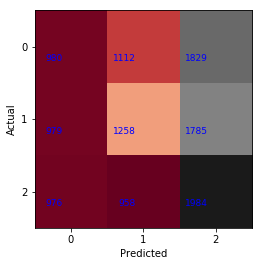

_End: 18:40:40 04/02/18 UTC
_Trial: 2 Start: 18:40:40 04/02/18 UTC
_l_rate: 0.00001 mb_size: 128 network: [104] activation:  leaky_relu
Epoch 1 of 251 Loss: 2.03408 Test: 65.8% Val: 66.7% Rec: 0.00
Epoch 50 of 251 Loss: 0.76070 Test: 33.0% Val: 64.8% Rec: 0.47
Epoch 100 of 251 Loss: 0.55782 Test: 21.9% Val: 64.5% Rec: 0.47
Epoch 150 of 251 Loss: 0.43812 Test: 16.0% Val: 64.3% Rec: 0.47
Epoch 200 of 251 Loss: 0.35477 Test: 12.6% Val: 64.7% Rec: 0.47
Epoch 250 of 251 Loss: 0.30221 Test: 10.5% Val: 64.9% Rec: 0.47
_Final_Epoch  251: Val_error: 65.0% 
             precision    recall  f1-score   support

          0       0.33      0.29      0.31      3921
          1       0.38      0.32      0.35      4022
          2       0.36      0.47      0.41      3918

avg / total       0.36      0.36      0.35     11861

[[1119 1130 1672]
 [1099 1270 1653]
 [1151  922 1845]]


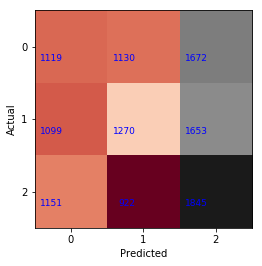

_End: 18:42:17 04/02/18 UTC
_Trial: 3 Start: 18:42:17 04/02/18 UTC
_l_rate: 0.00001 mb_size: 128 network: [104] activation:  leaky_relu
Epoch 1 of 251 Loss: 1.92203 Test: 66.3% Val: 66.8% Rec: 0.00
Epoch 50 of 251 Loss: 0.77641 Test: 34.1% Val: 64.7% Rec: 0.00
Epoch 100 of 251 Loss: 0.57600 Test: 22.5% Val: 64.4% Rec: 0.48
Epoch 150 of 251 Loss: 0.45403 Test: 16.7% Val: 64.5% Rec: 0.48
Epoch 200 of 251 Loss: 0.37280 Test: 13.4% Val: 64.6% Rec: 0.48
Epoch 250 of 251 Loss: 0.31506 Test: 11.0% Val: 64.6% Rec: 0.48
_Final_Epoch  251: Val_error: 64.6% 
             precision    recall  f1-score   support

          0       0.33      0.27      0.30      3921
          1       0.38      0.32      0.35      4022
          2       0.35      0.48      0.41      3918

avg / total       0.36      0.36      0.35     11861

[[1049 1107 1765]
 [1016 1280 1726]
 [1070  950 1898]]


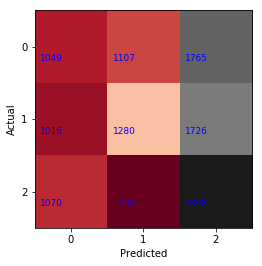

_End: 18:43:54 04/02/18 UTC
_Trial: 4 Start: 18:43:54 04/02/18 UTC
_l_rate: 0.00001 mb_size: 128 network: [104] activation:  leaky_relu
Epoch 1 of 251 Loss: 2.05372 Test: 65.5% Val: 65.5% Rec: 0.00
Epoch 50 of 251 Loss: 0.75917 Test: 33.0% Val: 64.7% Rec: 0.51
Epoch 100 of 251 Loss: 0.55834 Test: 22.0% Val: 65.0% Rec: 0.51
Epoch 150 of 251 Loss: 0.43788 Test: 16.1% Val: 64.8% Rec: 0.51
Epoch 200 of 251 Loss: 0.36067 Test: 12.7% Val: 65.0% Rec: 0.51
Early stopping at Epoch  217: Best Epoch   16:
Epoch 217 of 251 Loss: 0.33948 Test: 12.1% Val: 64.9% Rec: 0.51
_Final_Epoch  217: Val_error: 64.9% 
             precision    recall  f1-score   support

          0       0.33      0.23      0.27      3921
          1       0.38      0.33      0.35      4022
          2       0.35      0.51      0.41      3918

avg / total       0.35      0.35      0.35     11861

[[ 886 1144 1891]
 [ 901 1333 1788]
 [ 895 1035 1988]]


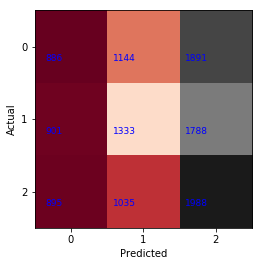

_End: 18:45:19 04/02/18 UTC
_Trial: 5 Start: 18:45:19 04/02/18 UTC
_l_rate: 0.00001 mb_size: 128 network: [104] activation:  leaky_relu
Epoch 1 of 251 Loss: 2.61183 Test: 67.2% Val: 65.7% Rec: 0.00
Epoch 50 of 251 Loss: 0.78294 Test: 34.8% Val: 64.3% Rec: 0.50
Epoch 100 of 251 Loss: 0.56774 Test: 22.6% Val: 64.2% Rec: 0.50
Epoch 150 of 251 Loss: 0.44897 Test: 16.8% Val: 64.3% Rec: 0.50
Epoch 200 of 251 Loss: 0.36453 Test: 12.9% Val: 64.4% Rec: 0.50
Epoch 250 of 251 Loss: 0.30761 Test: 10.7% Val: 64.5% Rec: 0.50
_Final_Epoch  251: Val_error: 64.4% 
             precision    recall  f1-score   support

          0       0.34      0.26      0.30      3921
          1       0.38      0.31      0.34      4022
          2       0.35      0.50      0.41      3918

avg / total       0.36      0.36      0.35     11861

[[1027 1080 1814]
 [1007 1263 1752]
 [ 997  965 1956]]


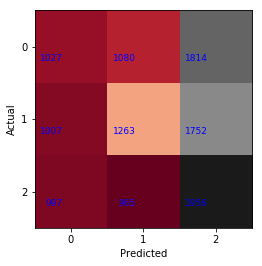

_End: 18:47:07 04/02/18 UTC
_Trial: 6 Start: 18:47:07 04/02/18 UTC
_l_rate: 0.00001 mb_size: 128 network: [104] activation:  leaky_relu
Epoch 1 of 251 Loss: 2.99397 Test: 69.1% Val: 67.4% Rec: 0.00
Epoch 50 of 251 Loss: 0.79128 Test: 35.1% Val: 64.9% Rec: 0.00
Epoch 100 of 251 Loss: 0.58194 Test: 22.9% Val: 64.8% Rec: 0.45
Epoch 150 of 251 Loss: 0.45755 Test: 17.1% Val: 64.9% Rec: 0.45
Epoch 200 of 251 Loss: 0.37127 Test: 13.2% Val: 64.7% Rec: 0.45
Epoch 250 of 251 Loss: 0.31437 Test: 11.0% Val: 64.7% Rec: 0.45
_Final_Epoch  251: Val_error: 64.7% 
             precision    recall  f1-score   support

          0       0.33      0.31      0.32      3921
          1       0.39      0.31      0.34      4022
          2       0.35      0.45      0.39      3918

avg / total       0.36      0.35      0.35     11861

[[1199 1071 1651]
 [1176 1242 1604]
 [1255  905 1758]]


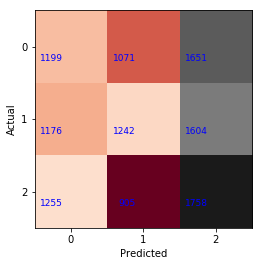

_End: 18:48:46 04/02/18 UTC
_Trial: 7 Start: 18:48:46 04/02/18 UTC
_l_rate: 0.00001 mb_size: 128 network: [104] activation:  leaky_relu
Epoch 1 of 251 Loss: 1.97161 Test: 65.9% Val: 65.1% Rec: 0.00
Epoch 50 of 251 Loss: 0.75789 Test: 32.9% Val: 64.6% Rec: 0.47
Epoch 100 of 251 Loss: 0.55949 Test: 21.8% Val: 64.3% Rec: 0.47
Epoch 150 of 251 Loss: 0.44156 Test: 16.2% Val: 64.1% Rec: 0.47
Epoch 200 of 251 Loss: 0.35764 Test: 12.8% Val: 64.4% Rec: 0.47
Epoch 250 of 251 Loss: 0.30953 Test: 10.7% Val: 64.6% Rec: 0.47
_Final_Epoch  251: Val_error: 64.5% 
             precision    recall  f1-score   support

          0       0.33      0.26      0.29      3921
          1       0.37      0.33      0.35      4022
          2       0.36      0.47      0.41      3918

avg / total       0.35      0.36      0.35     11861

[[1038 1200 1683]
 [1058 1329 1635]
 [1031 1033 1854]]


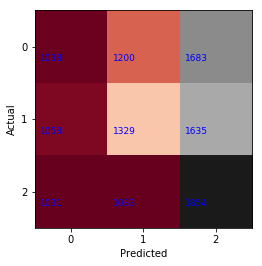

_End: 18:50:46 04/02/18 UTC
_Trial: 8 Start: 18:50:46 04/02/18 UTC
_l_rate: 0.00001 mb_size: 128 network: [104] activation:  leaky_relu
Epoch 1 of 251 Loss: 1.90113 Test: 65.5% Val: 66.5% Rec: 0.00
Epoch 50 of 251 Loss: 0.77282 Test: 34.1% Val: 64.9% Rec: 0.00
Epoch 100 of 251 Loss: 0.56861 Test: 22.3% Val: 64.8% Rec: 0.00
Epoch 150 of 251 Loss: 0.44371 Test: 16.3% Val: 64.6% Rec: 0.00
Epoch 200 of 251 Loss: 0.35873 Test: 12.7% Val: 64.8% Rec: 0.00
Early stopping at Epoch  201: Best Epoch    0:
Epoch 201 of 251 Loss: 0.36070 Test: 12.8% Val: 64.8% Rec: 0.00
_Final_Epoch  201: Val_error: 64.8% 
             precision    recall  f1-score   support

          0       0.35      0.26      0.30      3921
          1       0.31      0.20      0.25      4022
          2       0.33      0.53      0.41      3918

avg / total       0.33      0.33      0.32     11861

[[1015  916 1990]
 [ 994  823 2205]
 [ 926  921 2071]]


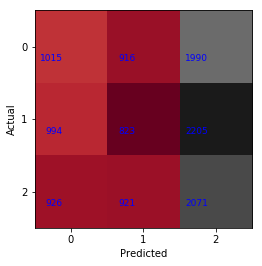

_End: 18:52:07 04/02/18 UTC
_Trial: 9 Start: 18:52:07 04/02/18 UTC
_l_rate: 0.00001 mb_size: 128 network: [104] activation:  leaky_relu
Epoch 1 of 251 Loss: 2.02150 Test: 66.5% Val: 68.1% Rec: 0.00
Epoch 50 of 251 Loss: 0.77165 Test: 33.5% Val: 64.9% Rec: 0.00
Epoch 100 of 251 Loss: 0.56629 Test: 22.3% Val: 64.8% Rec: 0.44
Epoch 150 of 251 Loss: 0.44998 Test: 16.6% Val: 65.1% Rec: 0.44
Epoch 200 of 251 Loss: 0.36661 Test: 13.0% Val: 65.4% Rec: 0.44
Epoch 250 of 251 Loss: 0.31524 Test: 11.2% Val: 65.4% Rec: 0.44
_Final_Epoch  251: Val_error: 65.4% 
             precision    recall  f1-score   support

          0       0.33      0.29      0.31      3921
          1       0.38      0.33      0.35      4022
          2       0.35      0.44      0.39      3918

avg / total       0.35      0.35      0.35     11861

[[1120 1162 1639]
 [1107 1327 1588]
 [1181  998 1739]]


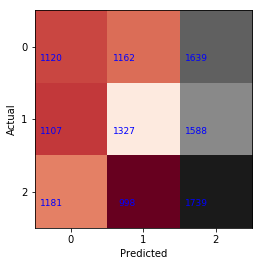

_End: 18:53:45 04/02/18 UTC
_Trial: 10 Start: 18:53:45 04/02/18 UTC
_l_rate: 0.00001 mb_size: 128 network: [104] activation:  leaky_relu
Epoch 1 of 251 Loss: 2.71899 Test: 69.4% Val: 67.4% Rec: 0.00
Epoch 50 of 251 Loss: 0.76948 Test: 33.5% Val: 65.2% Rec: 0.00
Epoch 100 of 251 Loss: 0.56447 Test: 22.2% Val: 65.1% Rec: 0.00
Epoch 150 of 251 Loss: 0.43965 Test: 16.4% Val: 65.0% Rec: 0.00
Epoch 200 of 251 Loss: 0.36220 Test: 12.9% Val: 64.8% Rec: 0.46
Epoch 250 of 251 Loss: 0.30368 Test: 10.6% Val: 64.9% Rec: 0.46
_Final_Epoch  251: Val_error: 64.9% 
             precision    recall  f1-score   support

          0       0.33      0.29      0.31      3921
          1       0.38      0.31      0.34      4022
          2       0.35      0.46      0.40      3918

avg / total       0.35      0.35      0.35     11861

[[1145 1121 1655]
 [1125 1256 1641]
 [1170  961 1787]]


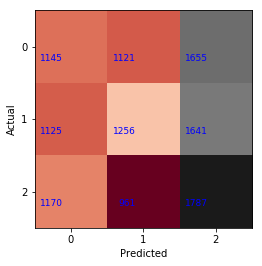

_End: 18:55:25 04/02/18 UTC
_Trial: 11 Start: 18:55:25 04/02/18 UTC
_l_rate: 0.00001 mb_size: 128 network: [104] activation:  leaky_relu
Epoch 1 of 251 Loss: 2.07758 Test: 65.7% Val: 65.2% Rec: 0.43
Epoch 50 of 251 Loss: 0.75549 Test: 33.1% Val: 64.4% Rec: 0.47
Epoch 100 of 251 Loss: 0.55791 Test: 21.6% Val: 64.4% Rec: 0.47
Epoch 150 of 251 Loss: 0.43817 Test: 16.0% Val: 64.4% Rec: 0.47
Epoch 200 of 251 Loss: 0.35846 Test: 12.7% Val: 64.5% Rec: 0.47
Early stopping at Epoch  220: Best Epoch   19:
Epoch 220 of 251 Loss: 0.33924 Test: 11.9% Val: 64.6% Rec: 0.47
_Final_Epoch  220: Val_error: 64.6% 
             precision    recall  f1-score   support

          0       0.33      0.27      0.30      3921
          1       0.39      0.33      0.36      4022
          2       0.35      0.47      0.41      3918

avg / total       0.36      0.36      0.35     11861

[[1052 1133 1736]
 [1040 1337 1645]
 [1063 1001 1854]]


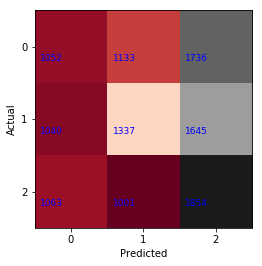

_End: 18:56:58 04/02/18 UTC
_Trial: 12 Start: 18:56:58 04/02/18 UTC
_l_rate: 0.00001 mb_size: 128 network: [104] activation:  leaky_relu
Epoch 1 of 251 Loss: 2.08372 Test: 67.3% Val: 67.5% Rec: 0.00
Epoch 50 of 251 Loss: 0.76346 Test: 33.6% Val: 64.8% Rec: 0.50
Epoch 100 of 251 Loss: 0.56548 Test: 22.1% Val: 64.7% Rec: 0.50
Epoch 150 of 251 Loss: 0.43791 Test: 16.2% Val: 64.7% Rec: 0.50
Epoch 200 of 251 Loss: 0.35956 Test: 12.6% Val: 64.7% Rec: 0.50
Early stopping at Epoch  235: Best Epoch   34:
Epoch 235 of 251 Loss: 0.32081 Test: 11.2% Val: 64.5% Rec: 0.50
_Final_Epoch  235: Val_error: 64.5% 
             precision    recall  f1-score   support

          0       0.32      0.24      0.28      3921
          1       0.39      0.32      0.35      4022
          2       0.35      0.50      0.41      3918

avg / total       0.35      0.35      0.35     11861

[[ 947 1102 1872]
 [ 982 1287 1753]
 [1014  946 1958]]


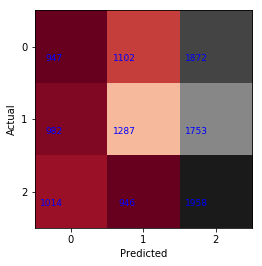

_End: 18:58:52 04/02/18 UTC
_Trial: 13 Start: 18:58:52 04/02/18 UTC
_l_rate: 0.00001 mb_size: 128 network: [104] activation:  leaky_relu
Epoch 1 of 251 Loss: 2.39530 Test: 67.9% Val: 67.9% Rec: 0.00
Epoch 50 of 251 Loss: 0.76169 Test: 33.3% Val: 64.7% Rec: 0.49


KeyboardInterrupt: 

In [24]:
trials = 501
num_epochs = 251
m = train_data.shape[0] # number of training examples
n_x = train_data.shape[1] # number of features 
n_y = train_labels.shape[1] # number of outputs: 0/1/2 for Down/Mid/Up

for trial in range(1,trials):
    l_rate, minibatch_size, n_ll, activation = random_select() 
    
    l_rate = 0.00001
    n_ll = [104]
    minibatch_size = 128
    activation = 'leaky_relu'
    
    print "_Trial:", trial, "Start:", (time.strftime('%X %x %Z'))
    print ("_l_rate: %1.5f mb_size: %2i network: %5s activation: %11s" 
       % (l_rate, minibatch_size, n_ll, activation))

    # Final network:
    
    n_l = n_ll[0] # number of nodes in the (first) hidden layer

    # This is where training samples and labels are fed to the graph.
    # These placeholder nodes will be fed a batch of training data at each
    # training step, which we'll write once we define the graph structure.
    train_data_node = tf.placeholder(tf.float32, shape=(minibatch_size, n_x))
    train_labels_node = tf.placeholder(tf.float32, shape=(minibatch_size, n_y))

    # For the validation and test data, we'll just hold the entire dataset in
    # one constant node. Note that test data will not be used in this stage.
    validation_data_node = tf.cast(tf.constant(validation_data), tf.float32)
    test_data_node = tf.cast(tf.constant(test_data), tf.float32)
    
    init_xavier = tf.contrib.layers.xavier_initializer()
    init_zeros = tf.zeros_initializer()
    
    fc1_weights = tf.Variable(init_xavier([n_x, n_l])) 
    fc1_biases = tf.Variable(init_zeros([n_l]))
    fc2_weights = tf.Variable(init_xavier([n_l, n_y]))
    fc2_biases = tf.Variable(init_zeros([n_y]))
    
    # Training computation: logits + cross-entropy loss.
    logits = model(train_data_node, activation, True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
      labels=train_labels_node, logits=logits))

    # L2 regularization for the fully connected parameters.
    regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
                    tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))
    # Add the regularization term to the loss.
    loss += 0.0001 * regularizers

    optimizer = tf.train.AdamOptimizer(l_rate, 0.9).minimize(loss) 

    # Predictions for the minibatch, validation set and test set.
    train_prediction = tf.nn.softmax(logits)
    # We'll compute them only once in a while by calling their {eval()} method.
    validation_prediction = tf.nn.softmax(model(validation_data_node, activation))
    test_prediction = tf.nn.softmax(model(test_data_node, activation))

    # Create a new interactive session that we'll use in
    # subsequent code cells.
    sess = tf.InteractiveSession()

    # Use our newly created session as the default for 
    # subsequent operations.
    sess.as_default()

    # Initialize all the variables we defined above.
    tf.global_variables_initializer().run()
    saver = tf.train.Saver()
    save_path = saver.save(sess,"/tmp/model.ckpt") #Initialized model 

    # Early stopping implemented from Goodfellow et al (p270)
    # Note: my version monitors test set accuracy
    # as opposed to validation set error in the book
    # e_ denotes a variable used in early stopping algorithm
    # The current best model is saved and restored using tensorflow

    e_i = 0    
    e_j = 0
    e_rstar = 0  # highest recall for 2
    e_istar = e_i
    e_p = 20  # patience: set to 250 in round 1, 20 in round 2
    e_n = 1    # number of steps between evaluations

    num_minibatches = int(train_data.shape[0] / minibatch_size)        
    
    for epoch in range(1,num_epochs+1):
        b_list = list(range(0, num_minibatches))
        random.shuffle(b_list)
        epoch_error = 0
        epoch_loss = 0

        for i in b_list:   
            batch_data = train_data[i:i+minibatch_size, :]
            batch_labels = train_labels[i:i+minibatch_size]

            feed_dict = {train_data_node: batch_data, train_labels_node: batch_labels}
            # Run the graph and fetch some of the nodes.
            _, l, predictions = sess.run(
              [optimizer, loss, train_prediction], feed_dict=feed_dict)
            error = error_rate(predictions, batch_labels)
            epoch_error += error
            epoch_loss += l

        if epoch % e_n == 0:
            epoch_error /= num_minibatches
            epoch_loss /= num_minibatches
            e_v = error_rate(validation_prediction.eval(), validation_labels)
            y_true = np.argmax(validation_labels,1)
            y_pred = np.argmax(validation_prediction.eval(),1)
            f1_2 = f1_score(y_true, y_pred, average = None)[2]
            recall_2 = recall_score(y_true, y_pred, average = None)[2]
            precision_2 = precision_score(y_true, y_pred, average = None)[2]

            # Early stopping test  
            e_i += e_n
            if ((precision_2 >= 0.35) & (e_rstar < recall_2)):
                e_j = 0
                e_istar = e_i
                e_rstar = recall_2
                save_path = saver.save(sess, "/tmp/model.ckpt") # Current best model
            else:
                e_j += 1
            if ((epoch == 1) | (epoch % 50 == 0)):
                print('Epoch %d of %d Loss: %.5f Test: %.1f%% Val: %.1f%% Rec: %.2f' %
                      (epoch, num_epochs, epoch_loss, epoch_error, e_v, e_rstar))      
                
            # Early stopping test    
            if e_j > e_p:
                print ("Early stopping at Epoch %4i: Best Epoch %4i:" % 
                       (epoch, e_istar))
                print('Epoch %d of %d Loss: %.5f Test: %.1f%% Val: %.1f%% Rec: %.2f' %
                      (epoch, num_epochs, epoch_loss, epoch_error, e_v, e_rstar))
                break
    saver.restore(sess, "/tmp/model.ckpt") 
    val_error = error_rate(validation_prediction.eval(), validation_labels)
    print ("_Final_Epoch %4i: Val_error: %.1f%% "  % (epoch,e_v))

    y_true = np.argmax(validation_labels,1)
    y_pred = np.argmax(validation_prediction.eval(),1)

    print classification_report(y_true, y_pred)
    print confusion_matrix(y_true, y_pred)
    
    confusions = np.zeros([3, 3], np.float32)
    bundled = zip(y_true, y_pred)
    for actual, predicted in bundled:
        confusions[actual, predicted] += 1

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.grid(False)
    plt.xticks(np.arange(3))
    plt.yticks(np.arange(3))
    plt.imshow(confusions, cmap=plt.cm.RdGy, interpolation='nearest')

    for i, cas in enumerate(confusions):
        for j, count in enumerate(cas):
            if count >= 0:
                xoff = .07 * len(str(count))
                plt.text(j-xoff, i+.2, int(count), fontsize=9, color='blue')
    plt.show() 
    
    print "_End:", (time.strftime('%X %x %Z'))